### Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install git+https://github.com/huggingface/transformers
!pip install datasets evaluate torch
!pip install accelerate -U

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-ael90z1w
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-ael90z1w
  Resolved https://github.com/huggingface/transformers to commit fce52cefa744a5900fc065aafb2f55d846d1202c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.40.0.dev0-py3-none-any.whl size=8806756 sha256=a2a889d2be8715bb79f5ee1ab1a672294fcfeb61ba58c240bf98c5de17b5ca3d
  Stored in directory: /tmp/pip-ephem-wheel-cache-nohy2nxu/wheels/c0/14/d6/6c9a5582d2ac191ec0a483be151a4495fe1eb2a6706ca49f1b
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM, TrainingArguments, Trainer, DataCollatorForLanguageModeling, AdamW

import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import random
import pandas as pd
import numpy as np
import math

In [ ]:
path = "/content/drive/MyDrive/Duke/Freshman Year/Sem 2/BME 590/Shrey Goel/Individual Project 2B"

In [ ]:
model_checkpoint = "facebook/esm2_t6_8M_UR50D"

### Prepare Data

In [ ]:
# DataLoader class

class CrisprDataset(Dataset):
    def __init__(self, path, tokenizer):
      self.data = pd.read_csv(path)
      self.tokenizer = tokenizer
      self.seqs = self.data['Sequence'].tolist()
      print(self.seqs)
      print(type(self.seqs))

    def __len__(self):
      return len(self.seqs)

    def __getitem__(self, idx):
      seqs = self.seqs[idx]
      inputs = self.tokenizer(seqs, truncation=True, max_length = 1000, padding=True,  return_tensors='pt')
      return {
          'input_ids': inputs['input_ids'].squeeze(),
          'attention_mask': inputs['attention_mask'].squeeze()
      }

In [ ]:
# Train-test split

def split_data(path, tokenizer, test_size = 0.2):
  data = CrisprDataset(path, tokenizer)
  train_df, test_df = torch.utils.data.random_split(data, [(len(data) - int(len(data)*test_size)), (int(len(data)*test_size))])
  return train_df, test_df

In [ ]:
# Load base ESM-2 8M parameter model and tokenizer for fine-tuning

tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = AutoModelForMaskedLM.from_pretrained("facebook/esm2_t6_8M_UR50D")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/31.4M [00:00<?, ?B/s]

In [ ]:
# Define collator function to group sequences into batches and define the number of tokens to be randomly masked
# This function ensures batches are of the same length by truncating or padding as necessary
# It also creates labels to associate residues to their respective tokens so the model can learn token representations from context
def collate_fn(tokenizer, mlm_probability):
  collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=mlm_probability)
  return collator

In [ ]:
# Random 80-20 split of data
train_esm_data, test_esm_data = split_data(path + '/anti_df.csv', tokenizer)

['MDEIEDLSDLPMPRFIWGFAVIAGKGGEVMHDEFEYLTHTRSPRFTCRVVELEDMPAESEEDAIDGRIVHDDDPSRMFYITDAGMALVNFQLFDKMPDKQKLKRICDEAIANWMLRREFLDEEEDD', 'MIDFNSIDHAIALIQKDPEQANAIAGEYAYQMAREAYEIASESGFGMEDEDFEDQLEFLINAGLVFDVQEAINKARSLHIANQSPC', 'MTTYYFSETSNINAYATAEALKAQTLADAKREASRRQCFQGTTLKIGTIYSLNSDGLLVDEITSKEDGKKWVDRY', 'MKSTYIIKEVQNINSDREGVKVETTSLTSAKRIASKNQFFHGTVLRIESESGNWLAYKEDGKRWIECE', 'MTIKLLDEFLKKHDLTRYQLSKLTGISQNTLKDQNEKSLNKYTVSILRSLSLISGLSVSDVLFELEDIEKNSDDLAGFKHLLGKYKLSFPAQEFELYCLIKEFESANIEVLPFTFNRFENETHVDIEKDVRKALENAITVLKEKKNELI', 'MTTFTSIVTTNPDFGGFEFYVEAGQQFDDSAYEEAYGVSVPSAVVEEVNAKAAQLKDGEWLNVSHEA', 'MTKFTSSVTTNPDFDGFNFYIEKGRQFDAEVYKEAYGINVPQDVIDDLNLKAEQLKDGEWLNVQHEA', 'MLYSEKVMDHFMHPRNVGEMENPSGVGEVGNAKCGDIMRMYLKIDENDIITDVKFKTYGCGTAIASSSMATELIKGKSINDAINLSNKEVAENLDGLPPIKMHCSVLAEEAIKAALYDYQEKSGHKVKGLENYEPPKDDLHDHEHVELD', 'MYNKAEIMKQAWNWFNNSNVWLSDIEWVSYTDKEKTFSVCLKAAWSKAKEEVEESKEESKHIAKSEELKAWNWAERKLGLHFNISDDEKFTSVKDETKINFGLSVWACAMKAVKLHNDLFPQTAA', 'MYNKAEIMKQAWNWFNDSNIWLSDIEWVSYTDKEKSFSVCLKAAWSKAKE

In [ ]:
# Apply collator function
collator = collate_fn(tokenizer, 0.15)

### Training model

In [ ]:
"""
Here, we fine-tune the ESM-2 8M parameter model on the MLM objective. We use train over 100 epochs with a learning rate of 0.0001
and a batch size of 2 due to limited compute. We also leverage the AdamW optimizer.
"""

In [ ]:
# Define training arguments object
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Duke/Freshman Year/Sem 2/BME 590/Shrey Goel/Individual Project 2B/finetuned_esm_mlm_head",
    overwrite_output_dir=True,
    logging_dir="/content/drive/MyDrive/Duke/Freshman Year/Sem 2/BME 590/Shrey Goel/Individual Project 2B/finetuned_esm_mlm_head/logs",
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    learning_rate=1e-4,
    num_train_epochs=100,
    #weight_decay=0.01,
    push_to_hub=False,
    save_strategy="epoch"
)

In [ ]:
# Define trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_esm_data,
    eval_dataset=test_esm_data,
    data_collator=collator,
    optimizers = (AdamW(model.parameters()), None)
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# train the model
trainer.train()

Epoch,Training Loss,Validation Loss
1,2.677200,2.580726
2,2.576700,2.426585
3,2.272200,2.260865
4,2.095900,2.166433
5,1.916300,2.046268
6,1.753600,1.950457
7,1.704300,1.915202
8,1.533600,1.769215
9,1.437600,1.819322
10,1.362900,1.633858


TrainOutput(global_step=7200, training_loss=0.5225974171360334, metrics={'train_runtime': 1253.8832, 'train_samples_per_second': 11.484, 'train_steps_per_second': 5.742, 'total_flos': 86737489759872.0, 'train_loss': 0.5225974171360334, 'epoch': 100.0})

### View training and testing results

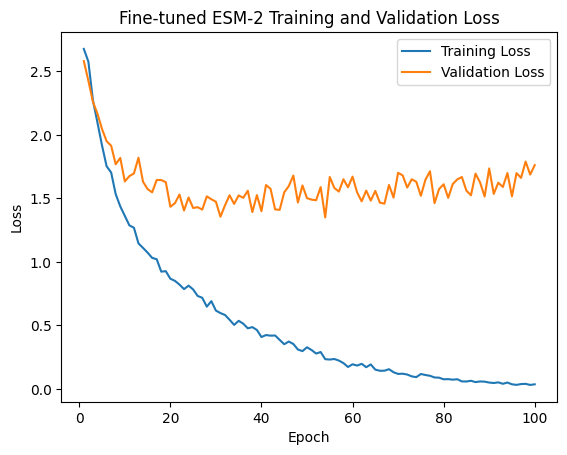

In [ ]:
# visualize the loss

df = pd.DataFrame(trainer.state.log_history)
train_loss = df['loss'].dropna().tolist()
# print(len(train_loss))
eval_loss = df['eval_loss'].dropna().tolist()
# print(len(eval_loss))
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, eval_loss[:len(train_loss)], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Fine-tuned ESM-2 Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Calculate perplexities to derive the model's "confusion" in its generated output. Thus, low pPLs indicate confidence in generation

test_results = trainer.evaluate()
print(f"Perplexity: {math.exp(test_results['eval_loss'])}")

Perplexity: 5.557020160340127


### Inference

In [ ]:
# load fine-tuned model and load original ESM-2 8M tokenizer
model = AutoModelForMaskedLM.from_pretrained("/content/drive/MyDrive/Duke/Freshman Year/Sem 2/BME 590/Shrey Goel/Individual Project 2B/finetuned_esm_mlm_head/checkpoint-7200")
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
# read in df with 10 anti-crispr sequences with lowest pPLs
top10_seqs = pd.read_csv("/content/drive/MyDrive/Duke/Freshman Year/Sem 2/BME 590/Shrey Goel/Individual Project 2B/plddt_ppls_top10_gen_seqs.csv")
top10_seqs

,Sequence,Perplexity,ESMFold_pLDDT,AlphaFold2_pLDDT
0,MTTFTSIVTTNPDFGGFEFYVEAGQQFDDSAYEEAYGVSVPTAVVE...,1.312910,67.13,90.8
1,MDEIDELSDLPTPRFIWGFAIAVTPSGEVSHDEFEYLTHTRSPRFT...,2.693028,36.17,90.1
2,MDEIDELSDLPTPRFIWGFAIAVTPDGKGGFEYISHDEYEAMTDEE...,3.134373,47.75,67.1
3,MDEIDELSDLPTPRFIWGFAIAVTPSGEVSHDEFEYLTHTRSPRFT...,3.302805,37.13,89.2
4,MDEIDELSDLPTPRFIWGFAIAVTPSGEVSHDEFEYLTHTRSPRFT...,3.458252,48.89,56.3
5,MDEIDELSDLPTPRFIWGFAIAVTPSGEVSHDEFEYLTHTRSPRFT...,3.940383,37.27,88.7
6,MTTFTSIVTTNPDFGGFEFYVEAGQQFDDSAYEEAYGVSVPTAVVE...,4.411345,67.23,88.2
7,MDEIDELSDLPTPRFIWGFAIAVTPSGEVSHDEFEYLTHTRSPRFT...,6.822530,38.17,64.6
8,MDEIDELSDLPTPRFIWGFAIAVTPSGEVSHDEFEYLTHTRSPRFT...,7.753764,38.24,84.6
9,MDEIDELSDLPTPRFIWGFAIAVTPSGEVSHDEFEYLTHTRSPRFT...,9.310184,37.89,83.8


In [ ]:
sequences = top10_seqs['Sequence'].tolist()

In [ ]:
"""
In the MLM objective, tokens (residues) are randomly masked and passed to the MLM head and the model is forced to uncover masked tokens.
In this training regimen, it is assumed the model will understand residue and sequence-level inputs and relationships in order to generate unmasked tokens.
A 15% random mask of tokens is convential and applied to the top 10 sequences. Thus, 15% of amino acids will be masked and the model will be forced to uncover them.
In this context, we assume unmasked tokens are the model's predictions of the best possible residue that would best contribute to the given anti-crispr sequence
given the context of the surrounding tokens.
"""

In [ ]:
# Apply the 15% random mask
def random_mask(sequences):
  results = []
  for sequence in sequences:
    num_masks = int(len(sequence) * 0.15) # number of residues to mask
    indices_to_mask = random.sample(range(len(sequence)), num_masks) # store indicies of masked amino acids

  # implement masking
    masked_seq = list(sequence)
    for idx in indices_to_mask:
        masked_seq[idx] = '<mask>'

    masked_seq = ''.join(masked_seq) # Make sequence back into string from list

    results.append(masked_seq)

  return results

In [ ]:
unmasked_seqs = top10_seqs['Sequence'].tolist()
masked_seqs = random_mask(unmasked_seqs)
print(masked_seqs)
print(len(masked_seqs))

['MTT<mask>TS<mask>V<mask>TNPDF<mask>GFEFYVEAGQQFDDSA<mask>EEA<mask>GVSVPTA<mask>VEE<mask>NAKAAQLKDGEW<mask>NVSHE<mask>', 'MDE<mask><mask>ELSDLP<mask>PRFIWGFAIAVTP<mask>G<mask><mask><mask>HDEFEYLTHTRSPRFTCRVVELE<mask><mask>PA<mask>PEXDEI<mask>GRIV<mask>F<mask>NPK<mask>M<mask>YITDL<mask>LALMN<mask>T<mask>FDKVDNKAKLKNACDEAIADWL<mask>RRDFIXXEDDED', 'M<mask>EIDELSDLP<mask>PRFIWGFAIAV<mask><mask>D<mask>KGGF<mask>YISHDEY<mask><mask>MTDEEKAEFEEEAA<mask>NREWLEGEFDG<mask>IDG<mask>IVHFDDAARMFFIT<mask><mask><mask>LA<mask>MNFT<mask><mask>DKVDNKAKLK<mask>ACDEAIAD<mask>LTRRDFLDSEEDDEE', 'MDEIDELSDLP<mask>PRFIW<mask>FA<mask>AVTP<mask>GEVSHDEFEYLTHTR<mask>PRFTCRV<mask>ELE<mask>MPAE<mask><mask>XDEIDGRI<mask>HF<mask>NP<mask><mask>MFYITDLGLALMNF<mask>L<mask><mask><mask>VD<mask>KAKLKNACDEAIADWLTR<mask>DFIXXSEDDDED', 'MDEIDELS<mask>LPTPR<mask>I<mask>GFAIAVTPSGEVSHDEFEY<mask>THTR<mask>P<mask>FTCRVVELED<mask>P<mask>E<mask>EDD<mask>DIDGR<mask><mask>HFENPKRMFY<mask>TD<mask>GLALMNFTLFDKV<mask>NKA<mask><mask>KNA

In [ ]:
# Uncover mutations in original sequence
mutated_seqs = []
for sequence in masked_seqs:
  txt = sequence
  inputs = tokenizer(txt, return_tensors="pt") # tokenize sequence

  with torch.no_grad():
    logits = model(**inputs).logits # generate logits (model predictions) of each token

  masked_token_idx = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1] # get indicies of masked tokens
  masked_token_logits = logits[0, masked_token_idx, :] # get logits of masked tokens

  top_token = torch.topk(masked_token_logits, 1, dim=1).indices[0].tolist() # select top predicted token for each masked token
  gen_seq = txt.replace(tokenizer.mask_token, tokenizer.decode([top_token[0]])) # replace random masks on masked sequence with predicted tokens
  mutated_seqs.append(gen_seq)

# display mutated sequences
mutated_seqs

['MTTFTSFVFTNPDFFGFEFYVEAGQQFDDSAFEEAFGVSVPTAFVEEFNAKAAQLKDGEWFNVSHEF',
 'MDEIIELSDLPIPRFIWGFAIAVTPIGIIIHDEFEYLTHTRSPRFTCRVVELEIIPAIPEXDEIIGRIVIFINPKIMIYITDLILALMNITIFDKVDNKAKLKNACDEAIADWLIRRDFIXXEDDED',
 'MKEIDELSDLPKPRFIWGFAIAVKKDKKGGFKYISHDEYKKMTDEEKAEFEEEAAKNREWLEGEFDGKIDGKIVHFDDAARMFFITKKKLAKMNFTKKDKVDNKAKLKKACDEAIADKLTRRDFLDSEEDDEE',
 'MDEIDELSDLPTPRFIWTFATAVTPTGEVSHDEFEYLTHTRTPRFTCRVTELETMPAETTXDEIDGRITHFTNPTTMFYITDLGLALMNFTLTTTVDTKAKLKNACDEAIADWLTRTDFIXXSEDDDED',
 'MDEIDELSDLPTPRDIDGFAIAVTPSGEVSHDEFEYDTHTRDPDFTCRVVELEDDPDEDEDDDDIDGRDDHFENPKRMFYDTDDGLALMNFTLFDKVDNKADDKNACDEAIADWLTRRDFLDSEEDDDEEAXPAKRDDKAEIDKQDWNWFNDSNVDLSDIEWDDYTDDEKTFSVCDDAAWSKADEEDIASSEDSEIDRDLEAVEDEDXLDDEIFYDAYEVLLDKDDAYKDFGKYEVDGVTYYINIVENEEYDEYDD',
 'MDEIDELSDLPTPRFIPGFAIAVPPSGEPSHDEFEPPTHPPSPRFTCRVVELEDMPPEPEXDEPDGRPVHFENPKRMFYITDLGLALMNFTLPDKVDPPAKLPNACDEPPADWLTRRPFIXXSDEEPDEE',
 'MTTFTSIVTTNPDFTGFEFYVEAGQQFDDSAYTETYGVSVPTATVEEMNAKAAQLKDGETLNVSHEATTETETDDET',
 'MDEIMELSDLPTPRFIWGFAIAVTPSGMMSHDEFEYLTHMMMPR

In [ ]:
top10_seqs.insert(1, "Mutated Sequence", mutated_seqs)
top10_seqs

,Sequence,Mutated Sequence,Perplexity,ESMFold_pLDDT,AlphaFold2_pLDDT
0,MTTFTSIVTTNPDFGGFEFYVEAGQQFDDSAYEEAYGVSVPTAVVE...,MTTFTSFVFTNPDFFGFEFYVEAGQQFDDSAFEEAFGVSVPTAFVE...,1.312910,67.13,90.8
1,MDEIDELSDLPTPRFIWGFAIAVTPSGEVSHDEFEYLTHTRSPRFT...,MDEIIELSDLPIPRFIWGFAIAVTPIGIIIHDEFEYLTHTRSPRFT...,2.693028,36.17,90.1
2,MDEIDELSDLPTPRFIWGFAIAVTPDGKGGFEYISHDEYEAMTDEE...,MKEIDELSDLPKPRFIWGFAIAVKKDKKGGFKYISHDEYKKMTDEE...,3.134373,47.75,67.1
3,MDEIDELSDLPTPRFIWGFAIAVTPSGEVSHDEFEYLTHTRSPRFT...,MDEIDELSDLPTPRFIWTFATAVTPTGEVSHDEFEYLTHTRTPRFT...,3.302805,37.13,89.2
4,MDEIDELSDLPTPRFIWGFAIAVTPSGEVSHDEFEYLTHTRSPRFT...,MDEIDELSDLPTPRDIDGFAIAVTPSGEVSHDEFEYDTHTRDPDFT...,3.458252,48.89,56.3
5,MDEIDELSDLPTPRFIWGFAIAVTPSGEVSHDEFEYLTHTRSPRFT...,MDEIDELSDLPTPRFIPGFAIAVPPSGEPSHDEFEPPTHPPSPRFT...,3.940383,37.27,88.7
6,MTTFTSIVTTNPDFGGFEFYVEAGQQFDDSAYEEAYGVSVPTAVVE...,MTTFTSIVTTNPDFTGFEFYVEAGQQFDDSAYTETYGVSVPTATVE...,4.411345,67.23,88.2
7,MDEIDELSDLPTPRFIWGFAIAVTPSGEVSHDEFEYLTHTRSPRFT...,MDEIMELSDLPTPRFIWGFAIAVTPSGMMSHDEFEYLTHMMMPRFM...,6.822530,38.17,64.6
8,MDEIDELSDLPTPRFIWGFAIAVTPSGEVSHDEFEYLTHTRSPRFT...,MDEIDELSDLPTPRFIWFFAFFVTPSGEVSHDFFEYLTHTRSFRFT...,7.753764,38.24,84.6
9,MDEIDELSDLPTPRFIWGFAIAVTPSGEVSHDEFEYLTHTRSPRFT...,MDEIDDLSDLPTPRFDDDDAIAVTPSGEVSDDEFEYLTHTRSPRFT...,9.310184,37.89,83.8


In [ ]:
top10_seqs.to_csv("/content/drive/MyDrive/Duke/Freshman Year/Sem 2/BME 590/Shrey Goel/Individual Project 2B/plddt_ppls_mutated_seqs.csv")